# Teste A|B, A|B Testing, Split Testing
Teste A|B é um teste  que divide o acesso a uma página online ou produto em duas versões diferentes, A(controle) e B(experimento), e depois mede-se a taxa de conversão que podem ser  vendas, clicks, preferência, compartilhamentos entre outras. As diferenças nas páginas/produtos podem ser em cores, botões, chamadas para ação ou serem totalmente diferentes mas com o mesmo objetivo final. No mundo offline é usado na indústria para lançamento de versões produtos para avaliar cores, tamanho e forma.

Suas aplicações são comuns em e-commerce e anúncios como Google Ads, Redes Sociais, email marketing e landing pages. Mesmo com aparência simples não é fácil encontrar variáveis relevantes estatísticamente para o experimento, isto é, é necessário grande quantidade de dados e tempo para rodar o teste. Este artigo detalha melhor o uso dos Testes A|B:[O que é Teste A|B](https://resultadosdigitais.com.br/blog/o-que-e-teste-ab/). 

O Teste A|B deve ser cuidadosamente projetado para obter resultados conclusivos e evitar enviesamento como descrito no artigo em inglês [7 A/B Testing Questions and Answers in Data Science Interviews](http://https://towardsdatascience.com/7-a-b-testing-questions-and-answers-in-data-science-interviews-eee6428a8b63).Esse material faz um apanhado da teoria do Teste A|B como questões de entrevista de emprego.


Também indico o podcast hipsters tech com o time da NetShoes e o material da página. Você pode acessar [aqui.](https://hipsters.tech/testes-ab-hipsters-59/).

[Experiments at Airbnb](https://medium.com/airbnb-engineering/experiments-at-airbnb-e2db3abf39e7) - Um case do Airbnb que mostra as armadilhas do Teste A|B e como evitar.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy 

# Explorando e conhecendo os dados

In [2]:
dados = pd.read_csv('../input/ab-testing/ab_data.csv')
dados.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
dados.shape

(294478, 5)

In [4]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


O dataset possui 5 colunas e 294478 linhas.
Nenhum valor nulo. 
A variável Id é numérica, mas é só de identificação e precisa ser verificada se há valores repetidos.
A variável converted é binária e significa se o usuário realizou a ação (1) ou não (0).
O teste é realizado ecom 2 grupos: control e treatment em duas páginas(landing-page)- a nova e a antiga.

## Tratamento dos dados

 
 


## 1 - Verificando se usuários do grupo de controle viram a nova página e vice versa

No Teste A|B é importante a independência e não interferência entre os grupos, por isso, removeremos os dados dos usuários do grupo de controle que entraram na nova página e vice-versa.

In [5]:
#separando os usuários de cada grupo que viu cada página.
dados.groupby(['group', 'landing_page']).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page       145274     145274     145274
treatment new_page       145311     145311     145311
          old_page         1965       1965       1965

In [6]:
#Filtrando somente os usuários que estão de acordo para nossa análise
dados_1 = dados.loc[(dados.group == 'control') & (dados.landing_page == 'old_page')
                   | (dados.group == 'treatment') & (dados.landing_page == 'new_page')]

In [7]:
#verificando 
dados_1.groupby(['group','landing_page']).count()

,,user_id,timestamp,converted
group,landing_page,,,
control,old_page,145274,145274,145274
treatment,new_page,145311,145311,145311


## 2 - Dados repetidos
Verificaremos de há usuários repetidos pelo Id.

In [8]:
dados_1.shape[0] == dados_1.user_id.nunique()  #False indica que há valores repetidos. Quantos?

False

In [9]:
dados_1.shape[0] - dados_1.user_id.nunique()
#significa que há usuários acessaram mais de uma vez.

1

In [10]:
# Encontrando o valor duplicado
dados_1[dados_1.duplicated(['user_id'], keep=False)]['user_id']

1899    773192
2893    773192
Name: user_id, dtype: int64

In [11]:
#buscando o usuário
dados_1[dados.user_id == 773192]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


O usuário do grupo de controle entrou duas vezes e não comprou em nenhuma delas. Para simplificar manteremos somente o primeiro registro.
Note que nossa decisão seria diferente no caso do usuário tivesse comprado.

In [12]:
dados_1 = dados.drop_duplicates(subset='user_id',keep='first')

# Explorando os dados - EDA

In [13]:
grupos = dados_1.groupby(['group','landing_page','converted']).size()
grupos

group      landing_page  converted
control    new_page      0               884
                         1               122
           old_page      0            126877
                         1             17349
treatment  new_page      0            127180
                         1             17134
           old_page      0               898
                         1               140
dtype: int64

<AxesSubplot:xlabel='group,landing_page,converted'>

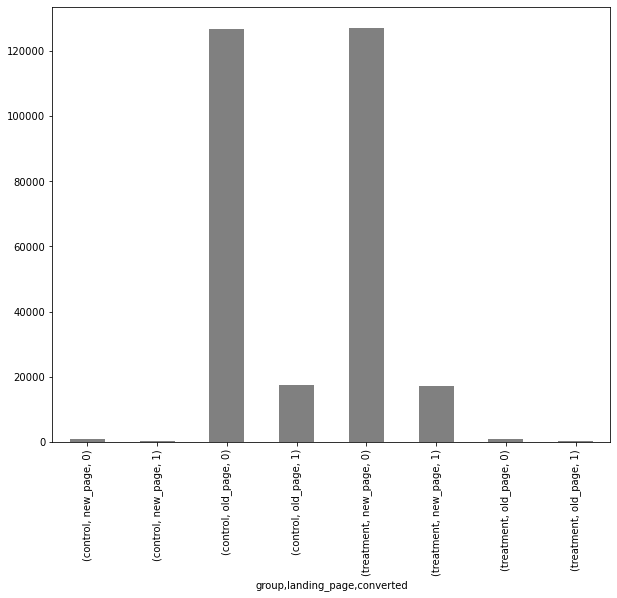

In [14]:
plt.figure(figsize=(10,8))
grupos.plot.bar(color='grey')



<AxesSubplot:ylabel='landing_page'>

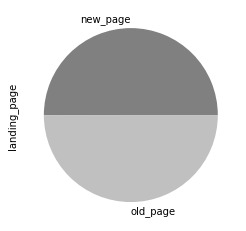

In [15]:
#verificando se a proporção em cada grupo é similar, isto é, se a amostra está balanceada. 
#Amostras desbalanceadas podem levar a enviesamento dos dados, por isso é importante ter uma representividade semelhante.
dados_1['landing_page'].value_counts().plot(kind='pie', colors=['grey','silver'])

# Taxa de Conversão

### Taxa de conversão geral

In [16]:
#taxa de conversão
conversao = pd.DataFrame(dados.converted.value_counts()/dados.shape[0] *100)
conversao

,converted
0,88.034081
1,11.965919


Text(0.5, 1.0, 'Taxa de conversão')

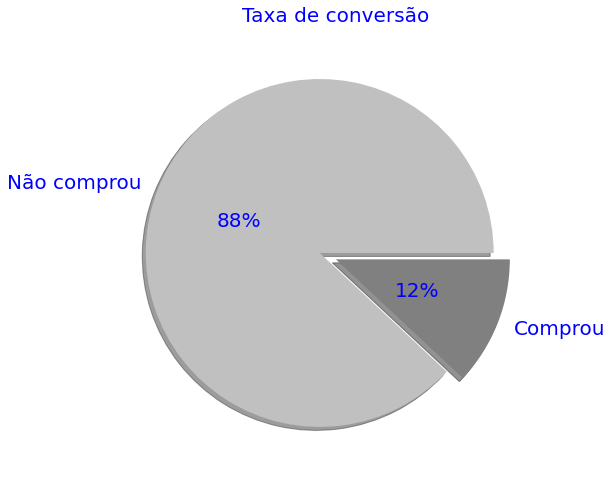

In [17]:
plt.figure(figsize=(10,8))

plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = 'b'
plt.rcParams['font.size']=20

cores = [ 'silver','gray']

percentages = list(conversao.converted)
explode=(0.1,0)
labels = ['Não comprou','Comprou']
plt.pie(percentages, explode=explode, 
       labels=labels,
       colors = cores,
       autopct='%1.0f%%',
       shadow=True, startangle=0,   
       pctdistance=0.5,labeldistance=1.1)
plt.title("Taxa de conversão", fontsize=20, pad=20)


### Taxa de conversão dos grupos

In [18]:
conversao_control = pd.DataFrame(dados_1[dados_1.group == 'control']['converted'].value_counts())
conversao_control['percentual'] = conversao_control.converted/ (conversao_control.converted.sum()) *100
conversao_control

,converted,percentual
0,127761,87.970282
1,17471,12.029718


In [19]:
conversao_treat = pd.DataFrame(dados_1[dados_1.group == 'treatment']['converted'].value_counts())
conversao_treat['percentual'] = conversao_treat.converted/ (conversao_treat.converted.sum()) *100
conversao_treat

,converted,percentual
0,128078,88.115747
1,17274,11.884253


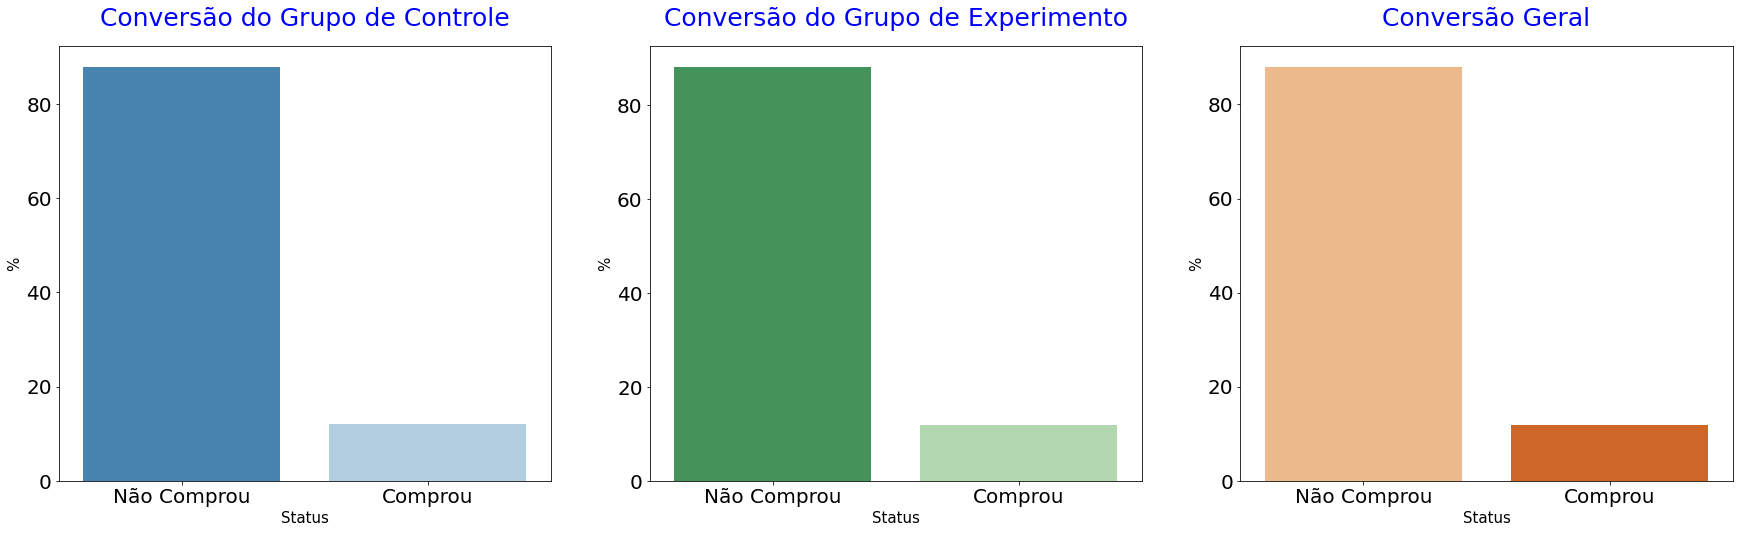

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

In [20]:
fig, (axis1, axis2, axis3) = plt.subplots(1,3, figsize=(30,8))

plt.figure(figsize=(10,8))
ax = sns.barplot(x=conversao_control.index, y="percentual", data=conversao_control, ax=axis1, palette = 'Blues_r')
ax.set_title("Conversão do Grupo de Controle", fontsize=25,pad=20)
ax.set_xlabel('Status', fontsize=15)
ax.set_ylabel('%', fontsize=15)
ax.set_xticklabels(labels=['Não Comprou', 'Comprou'])
plt.tight_layout()

plt.figure(figsize=(10,8))
ax = sns.barplot(x=conversao_treat.index, y="percentual", data=conversao_treat, ax=axis2, palette = 'Greens_r')
ax.set_title("Conversão do Grupo de Experimento", fontsize=25,pad=20)
ax.set_xlabel('Status', fontsize=15)
ax.set_ylabel('%', fontsize=15)
ax.set_xticklabels(labels=['Não Comprou', 'Comprou'])
plt.tight_layout()

plt.figure(figsize=(10,8))
ax = sns.barplot(x=conversao.index, y="converted", data=conversao, ax=axis3, palette = 'Oranges')
ax.set_title("Conversão Geral", fontsize=25,pad=20)
ax.set_xlabel('Status', fontsize=15)
ax.set_ylabel('%', fontsize=15)
ax.set_xticklabels(labels=['Não Comprou', 'Comprou'])
plt.tight_layout()


Visualmente não dá para notar muitas diferenças nos grupos, parecem que se comportam do mesmo modo. E estatísticamente?
Se você leu os artigos recomendados anteriormente, perceberás que esse tipo de situação é mais comum do que se imagina por isso o Teste A|B é tão importante.

# Teste A|B com Chi-quadrado

Chi-Quadrado, também conhecido como coeficiente de Pearson é um teste estatístico para comparar duas variáveis categóricas, independentes entre com pelo menos 5 observações. O teste verifica se as variáveis são homogêneas entre si.

A interpretação é realizada por meio de comparação com o p-value que , por convenção,abaixo de 0,05 há evidências de diferenças entre os grupos e acima disso não há diferenças significativas.

0. *H0* ou Hipótese nula - As variáveis possuem relação, p > 0,05.
1. *H1* ou Hipótese Alternativa - As variáveis não possuem relação, p < 0,05.

Abaixo deixo 1 artigo em português e 3 em inglês para melhor compreensão do assunto. Vale a pena a leitura!

[Teste Chi Quadrado de Pearson: um guia completo](https://sosestatistica.com.br/teste-chi-quadrado-pearson/#:~:text=O%20teste%20Chi%20Quadrado%20de,%C3%972%20(ou%20maiores).)

[Chi-Squared Test for Feature Selection with implementation in Python](https://towardsdatascience.com/chi-squared-test-for-feature-selection-with-implementation-in-python-65b4ae7696db)


[The Chi-Squared Test Statistic is a Must For Every Data Scientist: A Case Study in Customer Churn](https://towardsdatascience.com/the-chi-squared-test-statistic-is-a-must-for-every-data-scientist-a-case-study-in-customer-churn-bcdb17bbafb7)

[Ace the Interview: Chi-Squared Test](https://towardsdatascience.com/ace-the-interview-the-chi-squared-test-e6d37f681ea4)



## Rearranjando os dados em uma tabela 2x2 para aplicarmos o Chi-Quadrado.

In [21]:
dados_1

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [22]:
tabela_chi = pd.crosstab(dados_1.group,
                           dados.converted, normalize=False)

tabela_chi

converted,0,1
group,,
control,127761,17471
treatment,128078,17274


## Teste Chi-Quadrado

A função chi_contingence da biblioteca retorna 4 valores: chi_2, p_value, graus de liberdade e frequência esperada.

[Biblioteca](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html)

In [23]:
from scipy.stats import chi2_contingency


In [24]:
chi_2, p_value, gol,frequencia = scipy.stats.chi2_contingency(tabela_chi,correction=False)

# selecionando o nível de significãncia que por convenção é 0,05
alfa = 0.05
# Aceita ou rejeita H0?
print('significância=%.2f, p_value=%.2f, chi_2=%.2f' % (alfa, p_value,chi_2))
if p_value >= alfa:
    print('Não há diferenças entre as páginas,as variáveis são homogêneas. (aceitamos H0)')
else:
    print('Há indícios de que a conversão nas páginas é diferente, as variáveis são heterogêneas"  (rejeitamos H0 e aceitamos H1)')

significância=0.05, p_value=0.23, chi_2=1.46
Não há diferenças entre as páginas,as variáveis são homogêneas. (aceitamos H0)
